In [1]:
import os
import sys
from typing import Dict, Any

import numpy as np


project_root = os.path.abspath(os.path.join(os.getcwd(), '../../train', '..'))
app_root = os.path.abspath(os.path.join(project_root, '../../app', '..'))

if project_root not in sys.path:
    sys.path.append(project_root)
    sys.path.append(app_root)

In [2]:
from datasets_preprocessing import load_json_data, make_pipeline
import pandas as pd

math_pipeline = make_pipeline('math')

X_json_raw = load_json_data('datasets/math')
math_pipeline.fit_transform(X_json_raw)

math_df = pd.read_csv(os.path.join('csv_question_files', 'math.csv'))
math_df.head(10)

,question,tags_str,math,bio,code
0,Function on the unit circle and exponential,"complex-analysis,continuity",1,0,0
1,What does $\sum_{n=0}^\infty 1/n^n$ converge to?,"sequences-and-series,number-theory,limits",1,0,0
2,Random variable measurable with respect to sto...,"measure-theory,random-variables,stopping-times...",1,0,0
3,What is the distribution of 2 consecutive Bino...,"probability,binomial-coefficients,binomial-dis...",1,0,0
4,Determine lines intersecting four skew lines i...,"projective-geometry,projective-space,cross-ratio",1,0,0
5,How do you deal with absolute values in a func...,"calculus,solid-of-revolution",1,0,0
6,Aren't $ f’(xy) $ and $ f’(x/y)$ ambiguous not...,"multivariable-calculus,functions",1,0,0
7,Why do counits go that way?,"soft-question,category-theory,education,adjoin...",1,0,0
8,Not understanding a proof about coherent sheav...,"algebraic-geometry,proof-explanation,schemes,s...",1,0,0
9,Model theory of the naturals with a multiplica...,"model-theory,first-order-logic,nonstandard-models",1,0,0


In [3]:
bio_pipeline = make_pipeline('bio')

X_json_raw = load_json_data('datasets/bio')
bio_pipeline.fit_transform(X_json_raw)

bio_df = pd.read_csv(os.path.join('csv_question_files', 'bio.csv'))
bio_df.head(10)

,question,tags_str,math,bio,code
0,How many kg of seed can one expect from 230 kg...,agriculture,0,1,0
1,Adaptive Optics in Microscopy: what are the fa...,"biophysics,microscopy,fluorescent-microscopy,o...",0,1,0
2,Which part of the reflex arc takes the longest...,"human-biology,reflexes",0,1,0
3,Is wiping with RNAse Zap enough to destroy RNA...,"molecular-biology,lab-techniques,rna,lab-reagents",0,1,0
4,When there is incomplete dominance of one alle...,"genetics,terminology",0,1,0
5,Does drinking dry water have same effect as dr...,"human-biology,food",0,1,0
6,Do non-migratory canada geese still exhibit mi...,"ornithology,migration",0,1,0
7,"If life is discovered on another planet, will ...","taxonomy,astrobiology",0,1,0
8,Why do toenails grow much slower than fingerna...,"human-biology,human-anatomy",0,1,0
9,"Why do, humans, like many birds,tend to stand ...","brain,muscles,balance",0,1,0


In [4]:
code_pipeline = make_pipeline('code')

X_json_raw = load_json_data('datasets/code')
code_pipeline.fit_transform(X_json_raw)

code_df = pd.read_csv(os.path.join('csv_question_files', 'code.csv'))
code_df.head(10)

,question,tags_str,math,bio,code
0,WorkGroup Data Service with JSON / Web based API,"c#,linq,json",0,0,1
1,Design pattern for logger implementation,"object-oriented,design-patterns,salesforce-apex",0,0,1
2,Temperature calculator in Rust,"beginner,rust,unit-conversion",0,0,1
3,Read binary serial data and parse integers,"c#,serial-port",0,0,1
4,Brain-flak interpreter,"parsing,go,interpreter",0,0,1
5,Implement bash auto completion in Python,"python,python-3.x,bash,autocomplete",0,0,1
6,How well or poorly structured are my routes in...,"javascript,node.js",0,0,1
7,“Proper” Asynchronous implementation,"c#,asynchronous",0,0,1
8,Determining whether a loop iterated at least o...,"python,python-3.x,generator",0,0,1
9,Output JavaScript object into HTML table of ke...,"javascript,jquery",0,0,1


In [5]:
n_samples = 6000
half_samples = n_samples // 2

full_df = pd.concat(
	[
		math_df.sample(n=half_samples, random_state=42),
		bio_df.sample(n=half_samples , random_state=42),
		code_df.sample(n=n_samples, random_state=42)
	],
    ignore_index=True,
	axis=0
)

full_df

,question,tags_str,math,bio,code
0,How does rounding affect subsequent calculations?,rounding-error,1,0,0
1,Complex Hopf Fibration,"algebraic-geometry,differential-geometry,compl...",1,0,0
2,"Circular arrangement, probability of winning a...","probability,permutations",1,0,0
3,How many of the integers that satisfy the ineq...,"algebra-precalculus,inequality",1,0,0
4,A weaker Axiom of Infinity?,"set-theory,axioms",1,0,0
...,...,...,...,...,...
11995,Is the language $L=\{a^{2^{n}} \mid$ n is a na...,"formal-languages,context-free,pumping-lemma",0,0,1
11996,Status updates code design,java,0,0,1
11997,Hibernate Native Query,"java,hibernate",0,0,1
11998,Computing min and max using median of 3 elements,"algorithms,searching",0,0,1


# Math Model

## SVM + TF-IDF

In [6]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from train.reporting.sentence_transformer_sklearn_adapter import SentenceTransformerSklearnAdapter
from sklearn.pipeline import Pipeline
from train.reporting.model_interface import ModelInterface
from sklearn.svm import SVC

/home/xxxdkgxxx/PycharmProjects/BHL-solution/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
from sklearn.base import BaseEstimator, ClassifierMixin


class TextSVMWrapper(ModelInterface, BaseEstimator, ClassifierMixin):
    def predict_proba(self, X: np.ndarray) -> np.ndarray:
	    return self.model.predict_proba(X)

    def get_vectorizer(self):
	    return self.model.steps[0][1]

    def __init__(self):
        # Pipeline: Najpierw zamiana tekstu na liczby (TF-IDF), potem klasyfikator SVM
        self.model = Pipeline([
            ('tfidf', TfidfVectorizer(stop_words='english')),
            ('svm', SVC(C=1.0, random_state=42, probability=True, kernel='linear'))
        ])
        self.is_fitted = False

    def fit(self, X, y, X_val=None, y_val=None):
        # SVM w sklearn nie wspiera śledzenia historii loss per epoka w prosty sposób,
        # więc po prostu trenujemy model.
        self.model.fit(X, y)
        self.is_fitted = True

    def predict(self, X):
        return self.model.predict(X)

    def get_loss_history(self):
        # SVM ze sklearn nie udostępnia historii funkcji straty w czasie treningu.
        # Zwracamy pusty słownik, aby Reporter wiedział, że ma pominąć wykres.
        return {}

    def get_new_instance(self):
        # Zwraca nową, czystą instancję (potrzebne do Cross Validation w Reporterze)
        return TextSVMWrapper()

    def get_feature_importance(self):
        """
        Dla tekstu 'ważność cech' to słowa, które najsilniej wskazują na daną kategorię.
        """
        if not self.is_fitted:
            return {}

        try:
            feature_names = self.model.named_steps['tfidf'].get_feature_names_out()
            coefs = self.model.named_steps['svm'].coef_.copy()

            avg_coefs = np.mean(np.abs(coefs), axis=0)
            avg_coefs = np.ravel(avg_coefs)

            # Tworzymy słownik {słowo: waga}
            importance_dict = dict(zip(feature_names, avg_coefs))
            return importance_dict
        except Exception as e:
            print(f"Nie udało się pobrać ważności cech: {e}")
            return {}

In [8]:
from train.reporting.model_reporter import ModelReporter

report_df = full_df

target_category = 'code'

reporter = ModelReporter(TextSVMWrapper(), report_df['question'],
                         report_df[target_category])


In [9]:
reporter.generate_report()

[INFO] Raport zostanie zapisany w: reports/2026-01-22_10-55-28_TextSVMWrapper
Raport wygenerowany: 2026-01-22 10:55:28.407519
Model Wrapper: TextSVMWrapper
------------------------------
--- Rozpoczynanie treningu ---
Trening zakończony.
[INFO] Brak historii funkcji straty (Loss History). Pomijam wykres.
Zapisano macierz pomyłek: reports/2026-01-22_10-55-28_TextSVMWrapper/confusion_matrix.png

--- Uruchamianie 5-krotnej walidacji krzyżowej ---
Fold 5: 0.8962
Wyniki CV: [np.float64(0.8766666666666667), np.float64(0.8945833333333333), np.float64(0.8879166666666667), np.float64(0.89375), np.float64(0.89625)]
Średnia dokładność: 0.8898 (+/- 0.0072)

--- Top 10 Ważność cech ---
algorithm: 4.1397
complexity: 3.3385
array: 3.2044
implementation: 2.7419
floating: 2.6755
language: 2.6360
project: 2.5847
python: 2.4899
string: 2.4522
java: 2.4336
Generowanie wykresu 2D dla topowych cech (wersja uniwersalna)...
Wybrano cechy do wykresu: 'algorithm' oraz 'complexity'
Zapisano wykres 2D: reports/20

In [10]:
# reporter.plot_tsne()

In [11]:
# reporter.plot_wordclouds()

In [12]:
reporter.plot_confusion_matrix_with_0_as_few_classes(report_df.drop(columns=[target_category, "tags_str"])
                                                     .drop_duplicates(subset=["question"]))

Zapisano wykres korelacji predykcji z klasami: reports/2026-01-22_10-55-28_TextSVMWrapper/prediction_vs_true_class_correlation.png


Zapisano rozkład pewności modelu: reports/2026-01-22_10-55-28_TextSVMWrapper/confidence_distr_plot.png


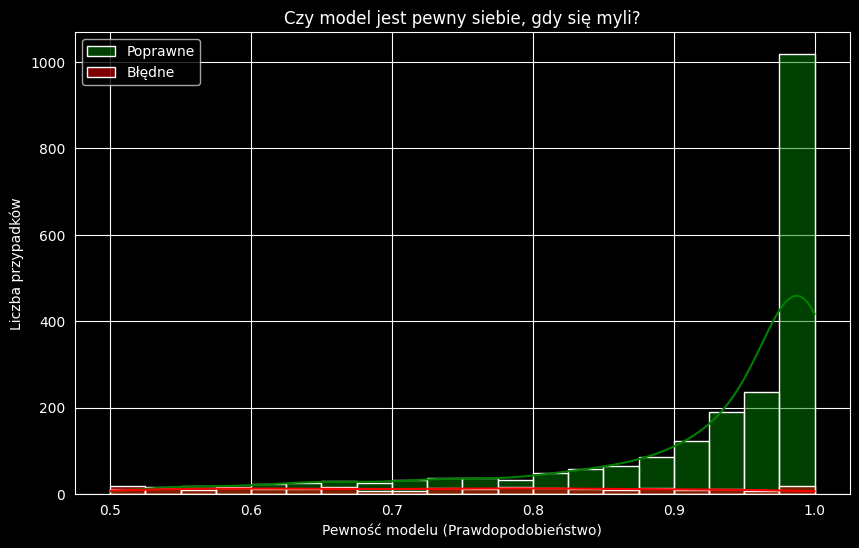

In [13]:
reporter.plot_confidence_distribution()